# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [7]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Definitions
## Model(Code 5) with Batch norm

In [5]:
dropout_value = 0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) 
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             192
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,296
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

## Model(Code 5) with GBM

In [6]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [18]:
## Model with GBN instead OF BN
dropout_value = 0
class Net_GBN(nn.Module):
    def __init__(self):
        super(Net_GBN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, 2),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, 2),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            GhostBatchNorm(12, 2),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            GhostBatchNorm(12, 2),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            GhostBatchNorm(12, 2),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            GhostBatchNorm(24, 2),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            GhostBatchNorm(16, 1),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) 
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net_GBN().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
    GhostBatchNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             192
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,296
             ReLU-12           [-1, 12, 10, 10]               0
   GhostBatchNorm-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

# Training and Testing

We are training 5 models:
* L1_BN
* L2_BN
* L1+L2+BN
* GBN
* L1+L2+GBN

We are storing loss and accuracies for all the models in dictionary.  We are addding L1 and L2 norm in the training loop.

In [12]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,lambda_l1=0):
  train_losses = []
  train_acc = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1=0
    for p in model.parameters():
      l1 = l1 +p.abs().sum()
    loss= loss +lambda_l1*l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return train_losses,train_acc

def test(model, device, test_loader):
    test_losses = []
    test_acc = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)


    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses,test_acc

# Let's Train and test our model

In [13]:
from torch.optim.lr_scheduler import StepLR

def train_model(lambda_l1=0,weight_decay=0,batch_norm='BN',name='Model',epochs=25):

  train_losses_values = []
  test_losses_values = []
  train_acc_values = []
  test_acc_values = []
  if batch_norm=='BN':
    model =  Net().to(device)
  elif batch_norm=='GBN':
    model= Net_GBN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  
  EPOCHS = epochs
  print('\n'+name+'\n')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses_batch,train_acc_batch=train(model, device, train_loader, optimizer, epoch,lambda_l1=lambda_l1)
    scheduler.step()
    test_losses_batch,test_acc_batch=test(model, device, test_loader)
    train_losses_values.extend(train_losses_batch)
    test_losses_values.extend(test_losses_batch)
    train_acc_values.extend(train_acc_batch)
    test_acc_values.extend(test_acc_batch)
  return train_losses_values,test_losses_values,train_acc_values,test_acc_values,model

In [14]:
## list of Tuples of the folrm (l1_mabda,weight_decay,Batch norm type('BN'/'GBN'),Name)
experiments=[(0.01,0,'BN','L1+BN'),(0,4e-4,'BN','L2+BN'),(0.01,4e-4,'BN','L1+L2+BN'),(0,0,'GBN','GBN'),(0.01,4e-4,'GBN','L1+L2+GBN')]

In [15]:
train_losses_dict = {}
test_losses_dict = {}
train_acc_dict = {}
test_acc_dict = {}
model_dict={}
for i in experiments:
  l1_lambda,weight_decay,batch_norm,name=i
  print(f'Config:{l1_lambda,weight_decay,batch_norm,name}')
  train_losses_dict[name],test_losses_dict[name],train_acc_dict[name],test_acc_dict[name],model_dict[name]=train_model(l1_lambda,weight_decay,batch_norm,name,epochs=25)

  0%|          | 0/469 [00:00<?, ?it/s]

Config:(0.01, 0, 'BN', 'L1+BN')

L1+BN

EPOCH: 0


Loss=1.9275768995285034 Batch_id=468 Accuracy=89.37: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7547, Accuracy: 7420/10000 (74.20%)

EPOCH: 1


Loss=1.2392305135726929 Batch_id=468 Accuracy=93.87: 100%|██████████| 469/469 [00:37<00:00, 12.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2535, Accuracy: 5629/10000 (56.29%)

EPOCH: 2


Loss=1.1656047105789185 Batch_id=468 Accuracy=93.72: 100%|██████████| 469/469 [00:37<00:00, 12.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4482, Accuracy: 8580/10000 (85.80%)

EPOCH: 3


Loss=1.0340436697006226 Batch_id=468 Accuracy=93.84: 100%|██████████| 469/469 [00:37<00:00, 12.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3542, Accuracy: 9058/10000 (90.58%)

EPOCH: 4


Loss=1.1837663650512695 Batch_id=468 Accuracy=93.95: 100%|██████████| 469/469 [00:38<00:00, 12.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0442, Accuracy: 6656/10000 (66.56%)

EPOCH: 5


Loss=1.1789038181304932 Batch_id=468 Accuracy=93.88: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4076, Accuracy: 8888/10000 (88.88%)

EPOCH: 6


Loss=0.7478650212287903 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1399, Accuracy: 9629/10000 (96.29%)

EPOCH: 7


Loss=0.7071157097816467 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:37<00:00, 12.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1475, Accuracy: 9625/10000 (96.25%)

EPOCH: 8


Loss=0.7280537486076355 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:37<00:00, 12.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1363, Accuracy: 9611/10000 (96.11%)

EPOCH: 9


Loss=0.7879899740219116 Batch_id=468 Accuracy=96.57: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1320, Accuracy: 9696/10000 (96.96%)

EPOCH: 10


Loss=0.7284390926361084 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1267, Accuracy: 9679/10000 (96.79%)

EPOCH: 11


Loss=0.6174983382225037 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1790, Accuracy: 9474/10000 (94.74%)

EPOCH: 12


Loss=0.6193100214004517 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9882/10000 (98.82%)

EPOCH: 13


Loss=0.5777938961982727 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:37<00:00, 12.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9857/10000 (98.57%)

EPOCH: 14


Loss=0.6004550457000732 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9874/10000 (98.74%)

EPOCH: 15


Loss=0.5376093983650208 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0676, Accuracy: 9865/10000 (98.65%)

EPOCH: 16


Loss=0.5285210013389587 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:37<00:00, 12.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9874/10000 (98.74%)

EPOCH: 17


Loss=0.6240757703781128 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:37<00:00, 12.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0739, Accuracy: 9852/10000 (98.52%)

EPOCH: 18


Loss=0.5592196583747864 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:38<00:00, 12.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9884/10000 (98.84%)

EPOCH: 19


Loss=0.5740154981613159 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0592, Accuracy: 9894/10000 (98.94%)

EPOCH: 20


Loss=0.6520798206329346 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:37<00:00, 12.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9888/10000 (98.88%)

EPOCH: 21


Loss=0.5331017971038818 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9885/10000 (98.85%)

EPOCH: 22


Loss=0.580609142780304 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9889/10000 (98.89%)

EPOCH: 23


Loss=0.5597513914108276 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9891/10000 (98.91%)

EPOCH: 24


Loss=0.5645762085914612 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:37<00:00, 12.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9888/10000 (98.88%)

Config:(0, 0.0004, 'BN', 'L2+BN')

L2+BN

EPOCH: 0


Loss=0.06681287288665771 Batch_id=468 Accuracy=92.00: 100%|██████████| 469/469 [00:37<00:00, 12.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9817/10000 (98.17%)

EPOCH: 1


Loss=0.026043405756354332 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.050769105553627014 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:37<00:00, 12.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Loss=0.041049182415008545 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:37<00:00, 12.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Loss=0.04372831806540489 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:37<00:00, 12.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.024482665583491325 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.017181796953082085 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.029513215646147728 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:37<00:00, 12.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.006898950319737196 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.03672640025615692 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.0027440607082098722 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:37<00:00, 12.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.003100080182775855 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:37<00:00, 12.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.003885387210175395 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.035323526710271835 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.022398533299565315 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.014816380105912685 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.0018348483135923743 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.00632067397236824 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:38<00:00, 12.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.009772541001439095 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:38<00:00, 12.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.0384061299264431 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.02219207026064396 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.0047960784286260605 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.005541990976780653 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.011330184526741505 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:37<00:00, 12.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.009296204894781113 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

Config:(0.01, 0.0004, 'BN', 'L1+L2+BN')

L1+L2+BN

EPOCH: 0


Loss=1.8560720682144165 Batch_id=468 Accuracy=87.95: 100%|██████████| 469/469 [00:37<00:00, 12.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3024, Accuracy: 9222/10000 (92.22%)

EPOCH: 1


Loss=1.2220618724822998 Batch_id=468 Accuracy=93.57: 100%|██████████| 469/469 [00:37<00:00, 12.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7172, Accuracy: 7717/10000 (77.17%)

EPOCH: 2


Loss=1.1449849605560303 Batch_id=468 Accuracy=93.33: 100%|██████████| 469/469 [00:37<00:00, 12.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8109, Accuracy: 7396/10000 (73.96%)

EPOCH: 3


Loss=1.1018729209899902 Batch_id=468 Accuracy=93.34: 100%|██████████| 469/469 [00:38<00:00, 12.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9119, Accuracy: 7112/10000 (71.12%)

EPOCH: 4


Loss=1.1184451580047607 Batch_id=468 Accuracy=93.39: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3456, Accuracy: 6129/10000 (61.29%)

EPOCH: 5


Loss=1.0742779970169067 Batch_id=468 Accuracy=93.33: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3665, Accuracy: 8973/10000 (89.73%)

EPOCH: 6


Loss=0.7679808139801025 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:37<00:00, 12.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1401, Accuracy: 9689/10000 (96.89%)

EPOCH: 7


Loss=0.6874428987503052 Batch_id=468 Accuracy=96.34: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1480, Accuracy: 9594/10000 (95.94%)

EPOCH: 8


Loss=0.6595447659492493 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:37<00:00, 12.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1424, Accuracy: 9605/10000 (96.05%)

EPOCH: 9


Loss=0.6611050367355347 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1926, Accuracy: 9454/10000 (94.54%)

EPOCH: 10


Loss=0.7582337260246277 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1330, Accuracy: 9652/10000 (96.52%)

EPOCH: 11


Loss=0.6737924218177795 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:37<00:00, 12.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1288, Accuracy: 9649/10000 (96.49%)

EPOCH: 12


Loss=0.6001946926116943 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0771, Accuracy: 9843/10000 (98.43%)

EPOCH: 13


Loss=0.6080062389373779 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:37<00:00, 12.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0752, Accuracy: 9837/10000 (98.37%)

EPOCH: 14


Loss=0.6021476984024048 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Accuracy: 9843/10000 (98.43%)

EPOCH: 15


Loss=0.6263512372970581 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9770/10000 (97.70%)

EPOCH: 16


Loss=0.6714200973510742 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9824/10000 (98.24%)

EPOCH: 17


Loss=0.6361138820648193 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:37<00:00, 12.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9828/10000 (98.28%)

EPOCH: 18


Loss=0.5819211006164551 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:37<00:00, 12.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9852/10000 (98.52%)

EPOCH: 19


Loss=0.5551537275314331 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9853/10000 (98.53%)

EPOCH: 20


Loss=0.579937219619751 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9858/10000 (98.58%)

EPOCH: 21


Loss=0.5672401785850525 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9861/10000 (98.61%)

EPOCH: 22


Loss=0.5795865654945374 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9857/10000 (98.57%)

EPOCH: 23


Loss=0.5923783183097839 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0659, Accuracy: 9855/10000 (98.55%)

EPOCH: 24


Loss=0.6005423069000244 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9858/10000 (98.58%)

Config:(0, 0, 'GBN', 'GBN')

GBN

EPOCH: 0


Loss=0.15352657437324524 Batch_id=468 Accuracy=91.32: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9855/10000 (98.55%)

EPOCH: 1


Loss=0.15407605469226837 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:38<00:00, 12.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.0270535871386528 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.05231967195868492 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.04778371751308441 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.02939983271062374 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:38<00:00, 12.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.04470549523830414 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.019398082047700882 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:38<00:00, 12.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


Loss=0.005452857818454504 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.007707919459789991 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.015789980068802834 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.006833977997303009 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.007387905847281218 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.027280956506729126 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.017018845304846764 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.007093354593962431 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.02140667848289013 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.06545266509056091 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.09549348801374435 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.007044454570859671 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


Loss=0.04251441732048988 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.04661468788981438 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


Loss=0.023935547098517418 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.02101152576506138 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.0062356493435800076 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

Config:(0.01, 0.0004, 'GBN', 'L1+L2+GBN')

L1+L2+GBN

EPOCH: 0


Loss=1.9015837907791138 Batch_id=468 Accuracy=87.56: 100%|██████████| 469/469 [00:38<00:00, 12.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3851, Accuracy: 8774/10000 (87.74%)

EPOCH: 1


Loss=1.3275506496429443 Batch_id=468 Accuracy=93.72: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3758, Accuracy: 9008/10000 (90.08%)

EPOCH: 2


Loss=1.1724345684051514 Batch_id=468 Accuracy=93.40: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3750, Accuracy: 8928/10000 (89.28%)

EPOCH: 3


Loss=1.2969449758529663 Batch_id=468 Accuracy=93.19: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9395, Accuracy: 6861/10000 (68.61%)

EPOCH: 4


Loss=1.2406580448150635 Batch_id=468 Accuracy=93.37: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4814, Accuracy: 8482/10000 (84.82%)

EPOCH: 5


Loss=1.1636197566986084 Batch_id=468 Accuracy=93.19: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4185, Accuracy: 8705/10000 (87.05%)

EPOCH: 6


Loss=0.7391911149024963 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1260, Accuracy: 9735/10000 (97.35%)

EPOCH: 7


Loss=0.7282282710075378 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1566, Accuracy: 9666/10000 (96.66%)

EPOCH: 8


Loss=0.7158890962600708 Batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1657, Accuracy: 9529/10000 (95.29%)

EPOCH: 9


Loss=0.7128580212593079 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2051, Accuracy: 9463/10000 (94.63%)

EPOCH: 10


Loss=0.8100606799125671 Batch_id=468 Accuracy=96.29: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1819, Accuracy: 9531/10000 (95.31%)

EPOCH: 11


Loss=0.7736462354660034 Batch_id=468 Accuracy=96.35: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1450, Accuracy: 9636/10000 (96.36%)

EPOCH: 12


Loss=0.5885164737701416 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9850/10000 (98.50%)

EPOCH: 13


Loss=0.5699350833892822 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0714, Accuracy: 9847/10000 (98.47%)

EPOCH: 14


Loss=0.656169593334198 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9851/10000 (98.51%)

EPOCH: 15


Loss=0.649559497833252 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9844/10000 (98.44%)

EPOCH: 16


Loss=0.6193267107009888 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9864/10000 (98.64%)

EPOCH: 17


Loss=0.6239235401153564 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9842/10000 (98.42%)

EPOCH: 18


Loss=0.6167696714401245 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9870/10000 (98.70%)

EPOCH: 19


Loss=0.5636337995529175 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9865/10000 (98.65%)

EPOCH: 20


Loss=0.5811348557472229 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9868/10000 (98.68%)

EPOCH: 21


Loss=0.552704393863678 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9864/10000 (98.64%)

EPOCH: 22


Loss=0.6010357737541199 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9867/10000 (98.67%)

EPOCH: 23


Loss=0.570611834526062 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9869/10000 (98.69%)

EPOCH: 24


Loss=0.6204963326454163 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average loss: 0.0629, Accuracy: 9873/10000 (98.73%)



In [19]:
len(test_losses_dict['L1+BN']),len(test_acc_dict['L1+BN']),len(train_losses_dict['L1+BN']),len(train_losses_dict['L1+BN'])

(25, 25, 11725, 11725)

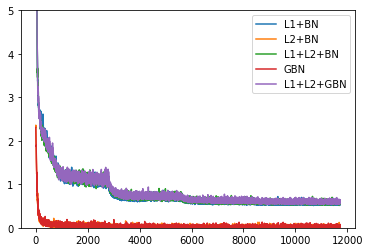

In [39]:
## training loss 
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)
legends=[]
for i in experiments:
  name=i[3]
  plt.axis(ymin=0,ymax=5)
  plt.plot(train_losses_dict[name])
  legends.append(name)
  #print(len(test_losses_dict[name]),len(test_acc_dict[name]),len(train_losses_dict[name]),len(train_losses_dict[name]))

plt.legend(legends, loc='upper right')

plt.show()

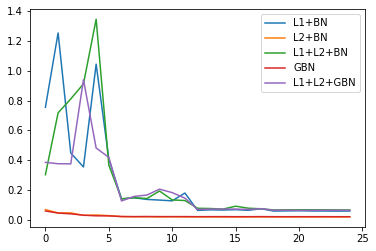

In [38]:
## test loss 
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)
legends=[]
for i in experiments:
  name=i[3]
  plt.plot(test_losses_dict[name])
  legends.append(name)
  #print(len(test_losses_dict[name]),len(test_acc_dict[name]),len(train_losses_dict[name]),len(train_losses_dict[name]))

plt.legend(legends, loc='upper right')

plt.show()

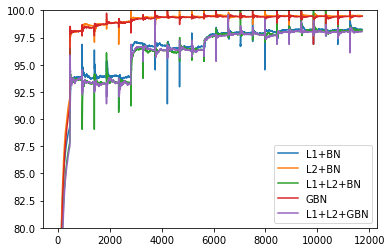

In [37]:
## train accuracy
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)
legends=[]
for i in experiments:
  name=i[3]
  plt.axis(ymin=80,ymax=100)
  plt.plot(train_acc_dict[name])
  legends.append(name)
  #print(len(test_losses_dict[name]),len(test_acc_dict[name]),len(train_losses_dict[name]),len(train_losses_dict[name]))

plt.legend(legends, loc='best')

plt.show()

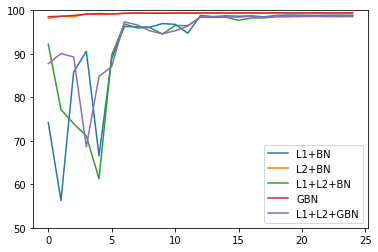

In [36]:
## Validation accuracy
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)
legends=[]
for i in experiments:
  name=i[3]
  plt.axis(ymin=50,ymax=100)
  plt.plot(test_acc_dict[name])
  legends.append(name)
  #print(len(test_losses_dict[name]),len(test_acc_dict[name]),len(train_losses_dict[name]),len(train_losses_dict[name]))

plt.legend(legends, loc='best')

plt.show()

# GBN Misclassifications:

In [41]:
incorrect_examples = []

model=model_dict['GBN']
model.eval()
for data,target in test_loader:
  data , target = data.cuda(), target.cuda()
  output = model(data)
  _, pred = torch.max(output,1)
  idxs_mask = ((pred == target) == False).nonzero()
  incorrect_examples.extend(data[idxs_mask].cpu().numpy())

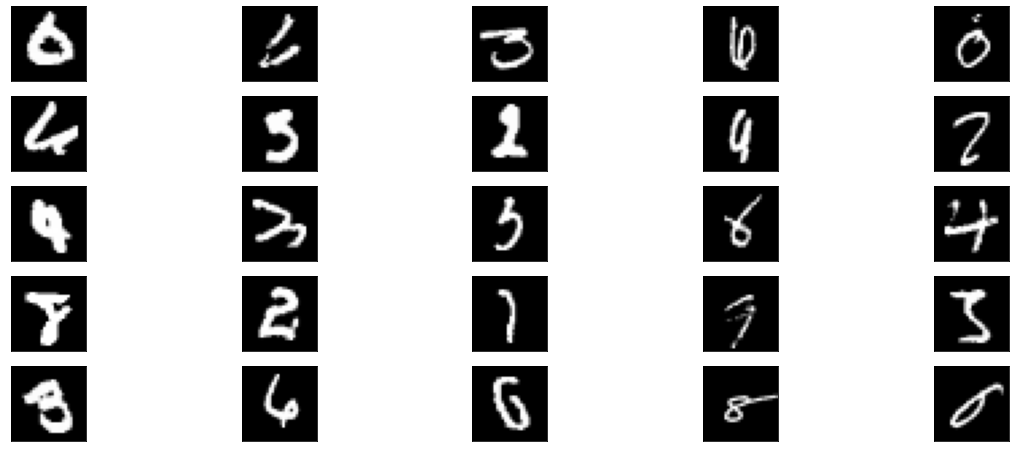

In [42]:
import numpy as np
from pylab import *

fig = plt.figure(figsize=(20, 8))

for idx in np.arange(25):
  ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])
  img = incorrect_examples[idx][0][0]
  imshow(img, cmap='gray')
 